# Automatic Music Transcription: Testing

After training the model, next step is the evaluate resultig models with standard metrics: Precision, Recall and F1.  <br>
In this notebook I will be testing two models: One based on LSTM and one basen on GRU.

In [ ]:
import numpy as np
import keras
import pretty_midi
import librosa

import os
import sys
import mir_eval
import glob

import numpy as np
import pandas as pd

sys.path.append("..")
sys.path.append("../src")

%load_ext autoreload
%autoreload 
from src import preprocess
from src import constants
from src import datagen
from src.infer import infer_from_processed
from src.metrics import pm_to_pitches_intervals, get_f1_score_notes, get_f1_score_frames, get_f1_score_notes_offsets
from src import helpers


## Step 1: Preprocessing
The first step is to preprocess the testing data. 
We provide the directory cointaining the dataset as well as a csv file containing information about train-test split. Resulted .npy files will be output to the directory provided in constants.py
For now I am using only 32 audio files for evaluating the models.

In [ ]:
dirname = '/floyd/input/new_maestro/'
preprocess.preprocess(dirname, False)

32


## Step 2: Testing
We must define a procedure for testing the model. At this point we've already preprocessed the files. All we have to do now is: <br>
1. Load the model we're testing.
2. Get all proprocess files and for each:
     1. infer from model.
     2. load preprocessed ground thruth labels.
     3. convert both ground and inference results to midi intrument form containing inofrmation about pitches, start and end times.
     4. Calculated Precision, Recall and F1 scores frame-wise, Note-wise and note-with-offset wise.
3. For each of three metrics take the mean of all single file scores.

In [3]:
def test_model(model):
    test_generator = datagen.DataGenerator(constants.TEST_PROCESSED_DIR, constants.SEQUENCE_SIZE, constants.BATCH_SIZE, constants.CONTEXT_WINDOW_SIZE, 'x_[0-9]+.npy', 'y_[0-9]+.npy')

    note_f1s = []
    note_precisions = []
    note_recalls = []
    
    note_f1s_offsets = []
    note_precisions_offsets = []
    note_recalls_offsets = []

    frame_f1s = []
    frame_precisions = []
    frame_recalls = []

    for sample in glob.glob(os.path.join(constants.TEST_PROCESSED_DIR, 'x_*')):
        isolated_filename = sample.split('/')[-1]

        gt_file= os.path.join(constants.TEST_PROCESSED_DIR,test_generator.corresponding_y(isolated_filename))
        referances = np.load(gt_file, mmap_mode='r')
        # preprocessed audio files are loaded with data generator and applied to a provided model
        predictions = infer_from_processed(model, sample) 
        
        # necesarry preprocessing for conversion into a midi file
        padded =  np.zeros((predictions.shape[0], 128))
        padded[:, 21:109] = predictions
        padded =  padded.T
        sequence_est = helpers.piano_roll_to_pretty_midi(padded, fs=32, program=0).instruments[0]
        padded =  np.zeros((referances.shape[0], 128))
        padded[:, 21:109] = referances
        padded =  padded.T
        sequence_ref = helpers.piano_roll_to_pretty_midi(padded, fs=32, program=0).instruments[0]
        
        # needed to get midi instrument objects for note based score calcultion 
        est_intervals,est_pitches = pm_to_pitches_intervals(sequence_est)
        ref_intervals,ref_pitches = pm_to_pitches_intervals(sequence_ref)
        
        #uses mir_eval library. note is presumed to be correct if it is within 50 ms range of groud truth note
        note_precision, note_recall, note_f1 = get_f1_score_notes(ref_intervals, ref_pitches, est_intervals, est_pitches)
        note_precision_offsets, note_recall_offsets, note_f1_offsets = get_f1_score_notes_offsets(ref_intervals, ref_pitches, est_intervals, est_pitches)
        
        # TP, FP and FN calculated across the entire frame array
        frame_precision, frame_recall, frame_f1 = get_f1_score_frames(referances, predictions)


        note_f1s.append(note_f1)
        note_precisions.append(note_precision)
        note_recalls.append(note_recall)
        
        note_f1s_offsets.append(note_f1_offsets)
        note_precisions_offsets.append(note_precision_offsets)
        note_recalls_offsets.append(note_recall_offsets)

        frame_f1s.append(frame_f1)
        frame_precisions.append(frame_precision)
        frame_recalls.append(frame_recall)


    # we calculate mean across all scores as done in Ondets and Frames paper for consistency
    avg_note_f1 = np.mean(note_f1s)
    avg_note_precision = np.mean(note_precisions)
    avg_note_recall = np.mean(note_recalls)
    
    avg_note_f1_offsets = np.mean(note_f1s_offsets)
    avg_note_precision_offsets = np.mean(note_precisions_offsets)
    avg_note_recall_offsets = np.mean(note_recalls_offsets)

    avg_frame_f1 = np.mean(frame_f1s)
    avg_frame_precision = np.mean(frame_precisions)
    avg_frame_recall = np.mean(frame_recalls)

    return {'frame_f1':avg_frame_f1,
            'frame_precision':avg_frame_precision, 
            'frame_recall':avg_frame_recall, 
            'note_f1':avg_note_f1, 
            'note_precision':avg_note_precision, 
            'note_recall':avg_note_recall,
            'note_f1_offsets':avg_note_f1_offsets, 
            'note_precision_offsets':avg_note_precision_offsets, 
            'note_recall_offsets':avg_note_recall_offsets}


### Test the models and compare the results
for each model tested, a dictionary will be returned containing all 9 scores for 3x3 metrics. In order to get some context for these results, we observe results from several other AMT models.<br>
Below is a table containing results from several models from the original Onsets and Frames paper, the model in the paper yielding the best results.

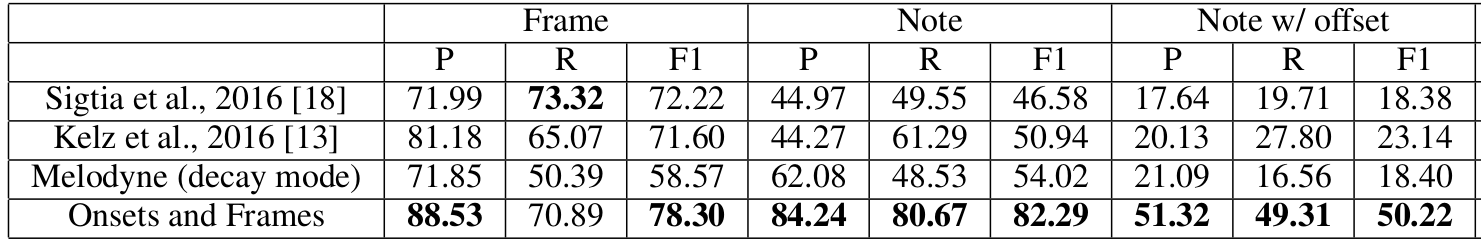

In [3]:
from IPython.display import Image
Image(filename='../AMT.png')

### Test LSTM based model

In [ ]:
metrics_lstm = test_model('/floyd/home/lstm_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


### Results
We present resulting dictionary as a pandas dataframe.

In [4]:
lstm_eval = pd.DataFrame({'Precison' : [metrics_lstm['frame_precision'],metrics_lstm['note_precision'], metrics_lstm['note_precision_offsets']], 
                   'Recall' : [metrics_lstm['frame_recall'],metrics_lstm['note_recall'], metrics_lstm['note_recall_offsets']],
                   'F1' : [metrics_lstm['frame_f1'],metrics_lstm['note_f1'], metrics_lstm['note_f1_offsets']],
                    '':['Frame', 'Note', 'Note w/ Offset']})

lstm_eval.set_index('')

,Precison,Recall,F1
,,,
Frame,0.755206,0.751454,0.750039
Note,0.637897,0.478511,0.540015
Note w/ Offset,0.245742,0.184697,0.209017


We can see from the table that results of frame-based metrics are much higher than those of note-based ones. While the f1 score beats out 3 out of 4 models it is compared to. Even though its note based metrics are lower than the frame based, this seems to be the case for most of the models presented. However LSTM model still underperforms when it comes to note-based recall, scoring the lowest point.

### Test GRU based model

In [4]:
metrics_gru = test_model('/floyd/home/gru_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


### Results

In [ ]:
gru_eval = pds.DataFrame({'Precison' : [metrics_gru['frame_precision'],metrics_gru['note_precision'],metrics_gru['note_precision_offsets']], 
                   'Recall' : [metrics_gru['frame_recall'],metrics_gru['note_recall'],metrics_gru['note_recall_offsets'] ],
                   'F1' : [metrics_gru['frame_f1'],metrics_gru['note_f1'], metrics_gru['note_f1_offsets']],
                    '':['Frame', 'Note', 'Note w/ offset']})


gru_eval.set_index('')

As seen above, GRU based model outperformed LSTM in
all categories other than frame recall. Though exact reason
behind why this is the case is hard to pinpoint, the results
could provide intuition for the type of transcriptions that will
result from the two models. Since precision is the measure of
false positives, its is expected of GRU based transcription to
be much “cleaner”. GRU also beats 3 out of 4 models in terms of note based f1 score. this model excels in both note and frame based
precision and scores second after the onsets and frames model. It is also worth noting that in terms of note-with-offset
evaluation GRU model has 3 out of for beat for every metric
other than recall. 

## Conclusions

Though the
modified models fall behind the dual-objective Onset and
Frames architecture, they seem to show great promise in terms
of certain metrics such as both note and frame-wise precision,
meaning that resulting transcription might be more modest but
significantly cleaner in terms of extra notes taken. This is
especially true for the GRU based language model.